In [1]:
%matplotlib inline

import matplotlib
import cv2, lmdb, os, glob
import scipy
import scipy.stats
import numpy as np
import msgpack
import msgpack_numpy
from matplotlib import pyplot as plt

plt.style.use("ggplot")
msgpack_numpy.patch()

In [2]:
import FileIO as fio
import Camera as camsolve
import Execution as exe

In [22]:
def draw_3d_normal_numpy(N, mu, sigma, itval=2.6):
    sigma_x, sigma_y, sigma_z = np.array(sigma) * 1.0341304822335893
    N_x, N_y, N_z = N
    mu_x, mu_y, mu_z = np.array(mu) + 0.06
    
    lo_x, hi_x = max(0, int(mu_x - itval * sigma_x)), min(int(mu_x + itval * sigma_x), N_x - 1)
    lo_y, hi_y = max(0, int(mu_y - itval * sigma_y)), min(int(mu_y + itval * sigma_y), N_y - 1)
    lo_z, hi_z = max(0, int(mu_z - itval * sigma_z)), min(int(mu_z + itval * sigma_z), N_z - 1)

    ker_x = scipy.stats.multivariate_normal.pdf(
        np.linspace(lo_x, hi_x, hi_x - lo_x, endpoint=False), 
        mean=mu_x, cov=sigma_x **2).reshape((-1, 1))
    ker_y = scipy.stats.multivariate_normal.pdf(
        np.linspace(lo_y, hi_y, hi_y - lo_y, endpoint=False), 
        mean=mu_y, cov=sigma_y **2).reshape((1, -1))
    ker_z = scipy.stats.multivariate_normal.pdf(
        np.linspace(lo_z, hi_z, hi_z - lo_z, endpoint=False), 
        mean=mu_z, cov=sigma_z **2).reshape((1, -1))

    ker = np.matmul(np.matmul(ker_x, ker_y)[..., np.newaxis], ker_z)
    ker /= np.sum(ker)
    
    grid = np.zeros((N_x, N_y, N_z))
    grid[lo_x:hi_x, lo_y:hi_y, lo_z:hi_z] += ker
    return grid

In [3]:
rt_path = "/scratch/zwang15/GPA_CVPR2019/GPA1.0"
ds_io = fio.GPA1Dataset(rt_path, rt_path)

In [4]:
imgid = ds_io.training_id[35754]
len(ds_io.training_id), len(ds_io.testing_id)

(237229, 86780)

In [15]:
res_z = 64
sigma_2d = 2
sigma_z = sigma_2d * 64 / 224 + 1

gt_rmse = []
with get_tqdm(total=0) as pbar:
    for imgid in ds_io.training_id[:7754]:
        imgfile, joints, camproj = ds_io.get_imgfile_joint_cam(imgid)
        joints17 = ds_io.select_joints(joints)
        imgpts = ds_io.proj_imgpts(joints17, camproj)
        z_offset = ds_io.z_offset(joints17, camproj)
        voxel_z = ds_io.zoffset_to_voxel_z(joints17, camproj, res_z)
        joint_grid = ds_io.voxelize_imgpts_voxelz(imgpts, voxel_z, (sigma_2d, sigma_2d, sigma_z), (224, 224, res_z))

        imgpts_pred = []
        rel_z_pred = []
        for grid in joint_grid:
            pred = np.unravel_index(np.argmax(grid), grid.shape)
            imgpts_pred.append(pred[:2])
            rel_z_pred.append(pred[2])
        pred_imgpts, pred_z = np.array(imgpts_pred), ds_io.voxel_z_to_zoffset(np.array(rel_z_pred), res_z)
        joints_pred = ds_io.combine_imgpts_zoffset(imgid, pred_imgpts, pred_z,)
        rmse = np.mean(np.sqrt(np.sum((ds_io.combine_imgpts_zoffset(imgid, pred_imgpts, pred_z) - joints17) ** 2, axis=1)))
        gt_rmse.append(rmse)
        pbar.update()

7754it [12:19, 10.49it/s]


In [22]:
new_grid = [g[:, :, :, np.newaxis] for g in joint_grid]
np.concatenate(new_grid, axis=3).shape

(224, 224, 64, 17)

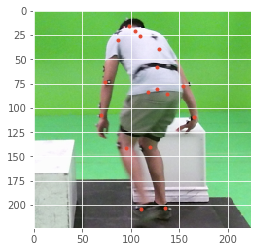

In [74]:
imgpts = ds_io.proj_imgpts(joints17, camproj)
plt.imshow(cv2.imread(imgfile)[:, :, ::-1])
plt.plot(imgpts[:, 0], imgpts[:, 1], ".")